In [1]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    print("No Cuda")

Running on the GPU


In [3]:
# parameters:
batch_size = 64
learning_rate = 0.001
momentum = 0.5
epoch = 10

### 先跑通一个项目：
Ref：https://blog.csdn.net/qq_45588019/article/details/120935828

In [2]:
# MNIST Download
# data preprocess:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=0.1307,std=0.3081)]
)
# get Dataset
train_dataset = datasets.MNIST(root=r'D:\\internWorkspace\\dataset',train=True,download=True,transform=transform)
test_dataset = datasets.MNIST(root=r'D:\\internWorkspace\\dataset',train=False,download=True,transform=transform)


train data shape:torch.Size([60000, 28, 28])
test data shape:torch.Size([10000, 28, 28])
train label shape:torch.Size([60000])
test label shape:torch.Size([10000])
single data shape:torch.Size([28, 28])


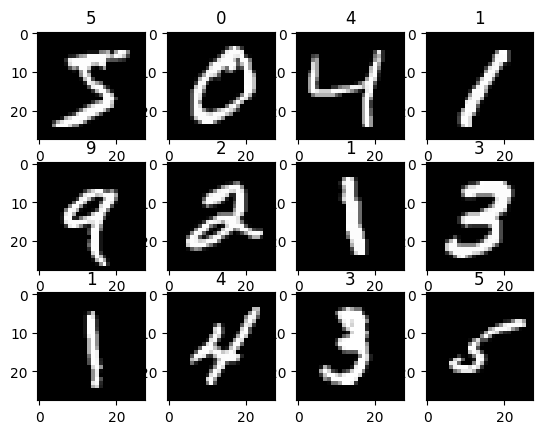

In [4]:
# show MNIST
# MNIST shape:
print("train data shape:{}".format(train_dataset.data.shape))
print("test data shape:{}".format(test_dataset.data.shape))
print("train label shape:{}".format(train_dataset.targets.shape))
print("test label shape:{}".format(test_dataset.targets.shape))
print("single data shape:{}".format(train_dataset.data[0].shape))
# img
fig = plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(train_dataset.data[i],cmap='gray')
    plt.title('{}'.format(train_dataset.targets[i]))
plt.show()
plt.close(fig)

In [35]:
# CNN 
class CNN_net(torch.nn.Module):
    def __init__(self):
        super(CNN_net,self).__init__() # 调用父类构造函数，继承父类的一些属性
        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,10,kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.cnn2 = torch.nn.Sequential(
            torch.nn.Conv2d(10,20,kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320,50),
            torch.nn.Linear(50,10)
        )

    def forward(self,x):
        batch_size = x.size(0)
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = x.view(batch_size,-1)
        x = self.fc(x)
        return x

In [17]:
class MyCNN(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super(MyCNN,self).__init__(*args, **kwargs)
        self.conv1 = torch.nn.Conv2d(1,10,kernel_size=5)
        self.maxpool= torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(10,20,kernel_size=5)
        self.fc1 = torch.nn.Linear(320,50)
        self.fc2 = torch.nn.Linear(50,10)

    def forward(self,x):
        batch_size = x.size(0)
        # first block
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        # seconde block
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        # linear
        x = x.view(batch_size,-1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [54]:
# create model:
CNN = CNN_net()
# CNN = MyCNN()

In [53]:
# dataloader
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size = batch_size,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size = batch_size,
                              shuffle=True)

In [57]:
# optimizer:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN.parameters(),lr=learning_rate)

In [48]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            inputs,targets = data
            outputs = CNN(inputs)

            _,predicted = torch.max(outputs.data,dim=1)
            correct+=(targets==predicted).sum().item()
            total += inputs.shape[0]
        acc = correct/total
    return acc

In [55]:
# train:
def train():
    epoch = 10
    loss_lists = []
    for e in range(epoch):
        train_loss = 0
        total = 0
        correct = 0
        for _ ,data in enumerate(train_dataloader):
            inputs,targets = data
            # train
            outputs = CNN(inputs)
            loss = criterion(outputs,targets)
            # loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # compute:
            train_loss += loss.item()
            _,predicted = torch.max(outputs.data,dim=1)
            total+=inputs.shape[0]
            correct+=(targets==predicted).sum().item()
            
            
        # save loss:
        loss_lists.append(loss.detach().numpy())
        acc = correct/total*100
        print("epoch {}: loss {} acc {}".format(e,loss,acc))

        if (e+1)%5==0:
            acc = test()
            print("Accuracy on test in epoch {}:{}%".format(e,acc*100))
        
    # show:
    fig = plt.figure()
    plt.plot(np.arange(0,len(loss_lists),1),loss_lists)
    plt.show()
    plt.close(fig)

epoch 0: loss 0.09601308405399323 acc 91.29
epoch 1: loss 0.0031613633036613464 acc 97.28
epoch 2: loss 0.004897576756775379 acc 97.78666666666666
epoch 3: loss 0.16583962738513947 acc 97.86
epoch 4: loss 0.15194891393184662 acc 97.82499999999999
Accuracy on test in epoch 4:98.2%
epoch 5: loss 0.006416266318410635 acc 97.69833333333334
epoch 6: loss 0.039574675261974335 acc 97.47333333333333
epoch 7: loss 0.03512060269713402 acc 97.42666666666666
epoch 8: loss 0.0008922955603338778 acc 97.465
epoch 9: loss 0.005199269391596317 acc 97.315
Accuracy on test in epoch 9:96.43%


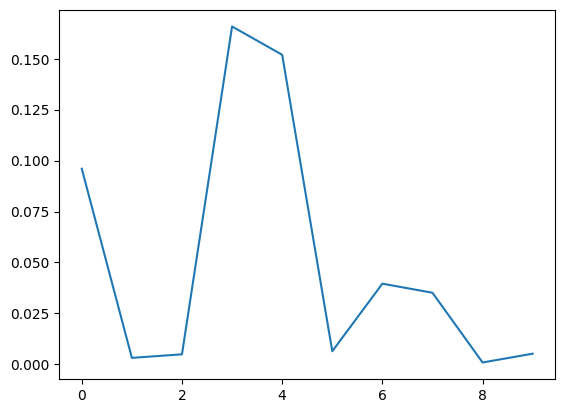

In [58]:
if __name__ == '__main__':
    train()

### Pretrained Model:
- ResNet18
- ResNet50
- AlexNet

#### ResNet18

In [4]:
import torchvision.models as models
import torchvision.utils as utils

In [5]:
def get_MNIST(transform):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Lambda(lambda x:x.repeat(3,1,1)),
         transform]
    )
    train_dataset = datasets.MNIST(root=r'D:\\InternWorkspace_wsr\\dataset',train=True,download=True,transform=transform)
    test_dataset = datasets.MNIST(root=r'D:\\InternWorkspace_wsr\\dataset',train=False,download=True,transform=transform)
    return train_dataset,test_dataset

In [85]:
def show_MNIST(train_dataset,test_dataset):
    # show MNIST
    # MNIST shape:
    print("train data shape:{}".format(train_dataset.data.shape))
    print("test data shape:{}".format(test_dataset.data.shape))
    print("train label shape:{}".format(train_dataset.targets.shape))
    print("test label shape:{}".format(test_dataset.targets.shape))
    print("single data shape:{}".format(train_dataset.data[0].shape))
    # img
    fig = plt.figure()
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(train_dataset.data[i],cmap='gray')
        plt.title('{}'.format(train_dataset.targets[i]))
    plt.show()
    plt.close(fig)

In [6]:
def get_dataloader(train_dataset,test_dataset):
    # dataloader
    train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size = batch_size,
                                shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size = 1,
                                shuffle=True)
    return train_dataloader,test_dataloader

In [7]:
# ResNet18
resnet18 = models.resnet18()
resnet18_weights = torch.load('./weights/resnet18-f37072fd.pth')
resnet18.load_state_dict(resnet18_weights)
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# # 第一种方法：直接修改
# modify parameter:
# fc output(原)：1000 -> 10
resnet18_fc_features = resnet18.fc.in_features
resnet18.fc = torch.nn.modules.Linear(resnet18_fc_features,10)

In [9]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# 第二种方法：冻结之前层的参数，微调最后一层
for param in resnet18.parameters():
    param.requires_grad = False
# 解冻fc层
for param in resnet18.fc.parameters():
    print(param)
    param.requires_grad = True

Parameter containing:
tensor([[-0.0427, -0.0308,  0.0200,  ..., -0.0438,  0.0166,  0.0272],
        [ 0.0051, -0.0232, -0.0432,  ..., -0.0107,  0.0264, -0.0118],
        [ 0.0052, -0.0243, -0.0424,  ...,  0.0048,  0.0224, -0.0375],
        ...,
        [ 0.0089, -0.0289, -0.0424,  ...,  0.0066, -0.0231,  0.0392],
        [ 0.0128,  0.0056, -0.0218,  ...,  0.0079, -0.0251, -0.0039],
        [ 0.0063,  0.0148,  0.0412,  ..., -0.0223, -0.0167, -0.0209]])
Parameter containing:
tensor([-0.0166, -0.0009, -0.0354,  0.0369, -0.0192,  0.0075,  0.0251, -0.0265,
         0.0250, -0.0247])


In [11]:
# preprcossed:
resnet18_trans = models.ResNet18_Weights.DEFAULT.transforms()
train_dataset,test_dataset = get_MNIST(resnet18_trans)
train_dataloader,test_dataloader = get_dataloader(train_dataset,test_dataset)

In [35]:
# Finetune ResNet18
# train:
def finetune(model,train_dataloader,model_path):
    model.train()
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

    loss_lists = []
    for e in tqdm(range(epoch)):
        train_loss = 0
        total = 0
        correct = 0
        for _ ,data in enumerate(train_dataloader):
            optimizer.zero_grad()
            inputs,targets = data
            # to GPU
            inputs,targets = inputs.to(device),targets.to(device)
            # train
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            # loss
            loss.backward()
            optimizer.step()
            
            # compute:
            train_loss += loss.item()
            _,predicted = torch.max(outputs.data,dim=1)
            total+=inputs.shape[0]
            correct+=(targets==predicted).sum().item()
            
            
        # save loss:
        loss_lists.append(loss.cpu().detach().numpy())
        acc = correct/total*100
        print("epoch {}: loss {} acc {}".format(e,loss,acc))
    
    # save model
    torch.save(model,model_path)
    print("Save Model in {} Successfully!".format(model_path))

    # show loss curve:
    fig = plt.figure()
    plt.plot(np.arange(0,len(loss_lists),1),loss_lists)
    plt.title("Loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()
    plt.close(fig)

  0%|          | 0/10 [00:00<?, ?it/s]d:\InternWorkspace_wsr\torchenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 10%|█         | 1/10 [00:54<08:12, 54.72s/it]

epoch 0: loss 0.151659294962883 acc 89.35833333333333


 20%|██        | 2/10 [01:49<07:15, 54.49s/it]

epoch 1: loss 0.4475891888141632 acc 94.26333333333334


 30%|███       | 3/10 [02:43<06:20, 54.40s/it]

epoch 2: loss 0.08777277916669846 acc 94.96333333333334


 40%|████      | 4/10 [03:37<05:26, 54.37s/it]

epoch 3: loss 0.26635265350341797 acc 95.27


 50%|█████     | 5/10 [04:31<04:31, 54.35s/it]

epoch 4: loss 0.17543566226959229 acc 95.65666666666667


 60%|██████    | 6/10 [05:26<03:37, 54.39s/it]

epoch 5: loss 0.19388991594314575 acc 95.80333333333333


 70%|███████   | 7/10 [06:20<02:42, 54.14s/it]

epoch 6: loss 0.24754203855991364 acc 95.98166666666667


 80%|████████  | 8/10 [07:13<01:48, 54.03s/it]

epoch 7: loss 0.29990190267562866 acc 96.09666666666666


 90%|█████████ | 9/10 [08:08<00:54, 54.07s/it]

epoch 8: loss 0.12026624381542206 acc 96.23666666666666


100%|██████████| 10/10 [09:02<00:00, 54.21s/it]

epoch 9: loss 0.08416131138801575 acc 96.17
Save Model in ./weights/checkpoints/Resnet18_ft.pth Successfully!


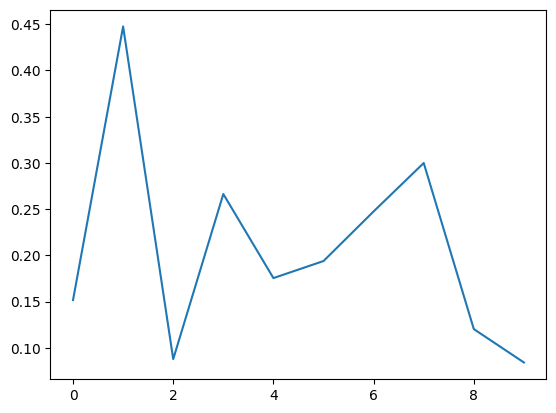

In [13]:
ResNet18_model_path = './weights/checkpoints/Resnet18_ft.pth'
finetune(resnet18,train_dataloader,ResNet18_model_path)

In [30]:
def predict(model,test_dataloader):
    model = model.to(device)
    # predict:
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in tqdm(test_dataloader):
            inputs,targets = data
            
            inputs,targets = inputs.to(device),targets.to(device)
            outputs = model(inputs)
            
            _,predicted = torch.max(outputs.data,dim=1)
            total += inputs.shape[0]
            correct+=(targets==predicted).sum().item()
            
    acc = correct/total*100
    print("Acc in test dataset: {}%".format(acc))

In [15]:
model_ft = torch.load(ResNet18_model_path)
predict(model_ft)

100%|██████████| 10000/10000 [00:21<00:00, 460.92it/s]

Acc in test dataset: 96.08


#### ResNet50
- ResNet50和ResNet18差不多，当任务较小时ResNet18已经够用了。
- 因此在此不对ResNet50 finetune.

In [95]:
# ResNet50
resnet50 = models.resnet50(pretrained = True)
# resnet50_weights = torch.load('./modelweights/resnet50-0676ba61.pth')
# resnet50.load_state_dict(resnet50_weights)
# resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [158]:
# 第一种方法：直接修改
# modify parameter:
# fc output(原)：1000 -> 10
fc_features = resnet50.fc.in_features
resnet50.fc = torch.nn.modules.Linear(fc_features,10)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [159]:
# preprocess data:
resnet50_trans = models.ResNet50_Weights.DEFAULT.transforms()
train_dataset,test_dataset = get_MNIST(resnet50_trans)
train_dataloader,test_dataloader = get_dataloader(train_dataset,test_dataset)

In [105]:
# Resnet50 predict:
# without finetune version:
predict(resnet50,test_dataloader)

d:\internWorkspace\torchenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([1, 8, 5, 3, 7, 6, 6, 2, 9, 5, 6, 5, 9, 2, 5, 0, 6, 0, 1, 2, 9, 0, 8, 3,
        0, 3, 3, 1, 2, 7, 2, 4, 2, 0, 3, 8, 9, 7, 7, 9, 7, 9, 1, 6, 8, 3, 9, 8,
        8, 6, 8, 9, 2, 8, 3, 2, 4, 6, 8, 4, 7, 4, 5, 3])
Accuracy on test:10.9375%


In [ ]:
# ResNet50 finetune:
ResNet50_model_path = './weights/checkpoints/ResNet50.pth'
finetune(resnet50,train_dataloader,ResNet50_model_path)

In [ ]:
# ResNet50 predict:
# with finetune version:
resnet50_ft = torch.load(ResNet50_model_path)
predict(resnet50_ft,test_dataloader)

#### AlexNet

In [20]:
# AlexNet
alexnet = models.alexnet()
alexnet_weights = torch.load('./weights/alexnet-owt-7be5be79.pth')
alexnet.load_state_dict(alexnet_weights)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
# 第一种方法：直接修改
# modify parameter:
# fc output(原)：1000 -> 10
alex_fc_features = alexnet.classifier[6].in_features
alexnet.classifier[6]= torch.nn.modules.Linear(alex_fc_features,10)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
# 第二种方法：冻结之前层的参数，微调最后一层
for param in alexnet.parameters():
    param.requires_grad = False
# 解冻fc层
for param in alexnet.classifier[6].parameters():
    param.requires_grad = True

In [23]:
# preprcossed:
alexnet_trans = models.AlexNet_Weights.DEFAULT.transforms()
train_dataset,test_dataset = get_MNIST(alexnet_trans)
train_dataloader,test_dataloader = get_dataloader(train_dataset,test_dataset)

d:\InternWorkspace_wsr\torchenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


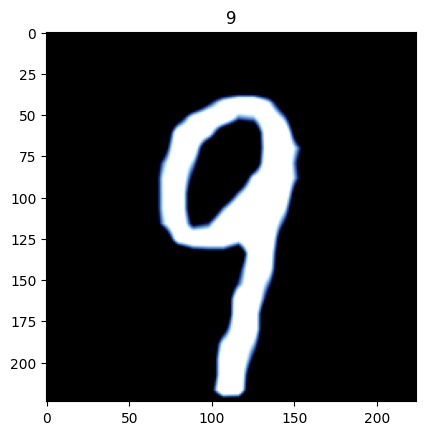

In [24]:
# Transform数据检查：
for _ ,data in enumerate(train_dataloader):
    inputs,targets = data
    fig = plt.figure()
    plt.imshow(inputs[1].permute(1,2,0))
    plt.title('{}'.format(targets[1]))
    plt.show()
    plt.close(fig)
    break

In [31]:
# AlexNet predict:
# without fintune version:
predict(alexnet,test_dataloader)

  0%|          | 0/10000 [00:00<?, ?it/s]d:\InternWorkspace_wsr\torchenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10000/10000 [00:13<00:00, 729.30it/s]

Acc in test dataset: 10.52%


  0%|          | 0/10 [00:00<?, ?it/s]d:\InternWorkspace_wsr\torchenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 10%|█         | 1/10 [00:45<06:51, 45.73s/it]

epoch 0: loss 0.2126571536064148 acc 85.795


 20%|██        | 2/10 [01:28<05:51, 43.95s/it]

epoch 1: loss 0.40800759196281433 acc 89.09166666666667


 30%|███       | 3/10 [02:11<05:03, 43.42s/it]

epoch 2: loss 0.7373389601707458 acc 89.47666666666667


 40%|████      | 4/10 [02:53<04:17, 42.99s/it]

epoch 3: loss 0.09468735009431839 acc 89.875


 50%|█████     | 5/10 [03:36<03:34, 42.94s/it]

epoch 4: loss 0.2705117166042328 acc 90.095


 60%|██████    | 6/10 [04:19<02:52, 43.07s/it]

epoch 5: loss 0.35319435596466064 acc 90.17833333333334


 70%|███████   | 7/10 [05:02<02:09, 43.10s/it]

epoch 6: loss 0.26488348841667175 acc 90.185


 80%|████████  | 8/10 [05:45<01:26, 43.08s/it]

epoch 7: loss 0.2226698100566864 acc 90.17833333333334


 90%|█████████ | 9/10 [06:29<00:43, 43.08s/it]

epoch 8: loss 0.3737737536430359 acc 90.48


100%|██████████| 10/10 [07:12<00:00, 43.21s/it]

epoch 9: loss 0.2767914831638336 acc 90.34166666666667


Save Model in ./weights/checkpoints/AlexNet.pth Successfully!


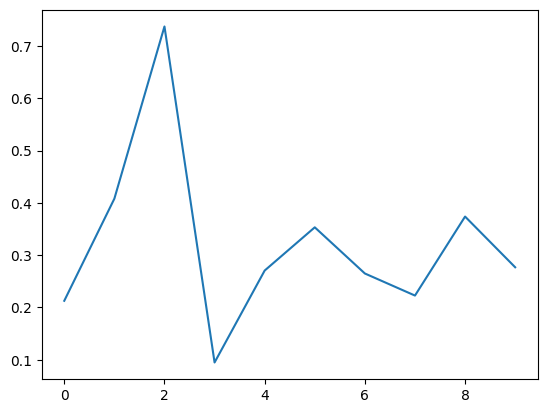

In [32]:
# AlexNet finetune:
alexnet_model_path = './weights/checkpoints/AlexNet.pth'
finetune(alexnet,train_dataloader,alexnet_model_path)

In [34]:
# AlexNet predict:
# with finetune version:
alexnet_ft = torch.load(alexnet_model_path)
predict(alexnet_ft,test_dataloader)

  0%|          | 0/10000 [00:00<?, ?it/s]d:\InternWorkspace_wsr\torchenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10000/10000 [00:13<00:00, 728.91it/s]

Acc in test dataset: 95.5%
